# Preparation

<b>Load Libraries</b>

In [1]:
# 
import os, sys
cwd = os.getcwd()
os.chdir('../../..')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.jupyter.support import *

# others
from sklearn.preprocessing import TargetEncoder
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
materials = prepare_data_to_train('../../../resource/data/cleaned.csv')

<b>MLflow</b>

In [3]:
# connect to local mlflow
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
##
mlflow.set_experiment('Feature engineering')

<Experiment: artifact_location='/home/xxo/lab/working/resource/mlflow/runs', creation_time=1724633706671, experiment_id='1', last_update_time=1724633706671, lifecycle_stage='active', name='Feature engineering', tags={}>

<b>UDC</b>

In [9]:
class SFSTransformer(FSBaseTransformer):
    def fit(self, X: np.ndarray, y=None):
        X, idxes = self.detect_category(X)
        ##
        transformers = dict()
        te = [i for i in idxes['cat'] if len(np.unique(X[:, i])) >= 10]
        ohe = [i for i in idxes['cat'] if i not in te]
        ##
        transformers['te'] = ('te', TargetEncoder(), te)
        transformers['ohe'] = ('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe)
        transformers['qtt'] = ('qtt', QuantileTransformer(output_distribution='normal'), idxes['num'])
        ##
        self.assigned_transformers = [transfomer for transfomer in transformers.values() if len(transfomer[-1]) != 0]

        super().fit(X, y)

        return self

# Testing

In [17]:
# warnings
simplefilter(action='ignore')

# base model
base_model = get_seleted_models(['LGBM'])

# transformers
transformers = SFSTransformer()

# evaluation
pipeline = Pipeline([('trans', transformers), base_model[0]])
sfs = SequentialFeatureSelector(pipeline, k_features='best', forward=True, 
                                scoring=make_scorer(fbeta_score, beta=2), 
                                cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
                                verbose=2)
sfs.fit(materials['X_train'], materials['y_train'])


[2024-08-29 07:46:05] Features: 1/19 -- score: 0.2615430521376435
[2024-08-29 07:46:55] Features: 2/19 -- score: 0.4249975876358692
[2024-08-29 07:47:46] Features: 3/19 -- score: 0.5565830140904715
[2024-08-29 07:48:41] Features: 4/19 -- score: 0.6104860556038509
[2024-08-29 07:49:39] Features: 5/19 -- score: 0.6506393149317705
[2024-08-29 07:50:39] Features: 6/19 -- score: 0.7173813855602608
[2024-08-29 07:51:47] Features: 7/19 -- score: 0.7923791545340584
[2024-08-29 07:52:43] Features: 8/19 -- score: 0.8124455861510163
[2024-08-29 07:53:28] Features: 9/19 -- score: 0.8136856672934619
[2024-08-29 07:54:13] Features: 10/19 -- score: 0.8141554075606534
[2024-08-29 07:54:57] Features: 11/19 -- score: 0.8102974445351251
[2024-08-29 07:55:41] Features: 12/19 -- score: 0.8092763017094486
[2024-08-29 07:56:20] Features: 13/19 -- score: 0.8094179283830935
[2024-08-29 07:56:55] Features: 14/19 -- score: 0.8114120408367745
[2024-08-29 07:57:26] Features: 15/19 -- score: 0.8103672242395771
[20

SequentialFeatureSelector(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
                          estimator=Pipeline(steps=[('trans', SFSTransformer()),
                                                    ('LGBM',
                                                     LGBMClassifier(n_jobs=-1,
                                                                    verbose=-1))]),
                          k_features=(1, 19),
                          scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                          verbose=2)

In [31]:
# warnings
simplefilter(action='ignore')

# base model
base_model = get_seleted_models(['LGBM'])

# feature selction
feature_selector = FunctionTransformer(func=lambda X, idxes: X[:, list(idxes)], kw_args={'idxes': sfs.k_feature_idx_})

# transformers
transformers = SFSTransformer()

# evaluation
pipeline = Pipeline([('fs', feature_selector), ('trans', transformers), ('ros', RandomOverSampler()), base_model[0]])
cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                             scoring=make_scorer(fbeta_score, beta=2), 
                             cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
print(f'LGBM: {cv_results.mean()} ({cv_results.std()})')
##
pipeline.fit(materials['X_train'], materials['y_train'])
val_predictions = pipeline.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, beta=2)

# 
with mlflow.start_run():
    ##
    mlflow.set_tags({'pre_pro': 'fs_ohe_qtt_ros', 'base_model': 'LGBM', 
                     'beta_f': 2})
    ## 
    mlflow.log_metrics({'avg_fbeta': cv_results.mean(),
                    'val_fbeta': val_fbeta})
    ##
    mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')

LGBM: 0.8290878218023605 (0.05852816383780893)


# Finalize

In [12]:
# load model
run_id = mlflow.search_runs(filter_string="tags.pre_pro LIKE 'fs%'")['run_id'].values[0]
model = mlflow.sklearn.load_model(f"runs:/{run_id}/model")

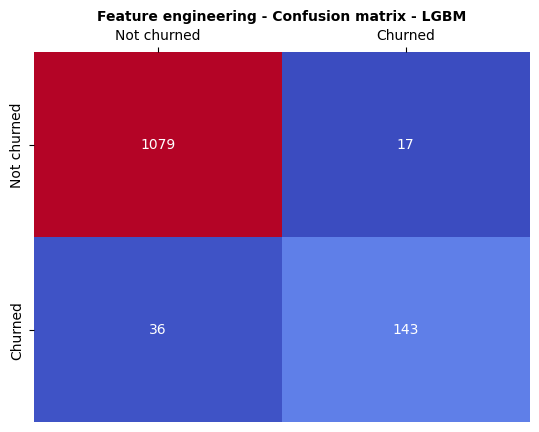

In [25]:
# confusion matrix
predictions = model.predict(materials['X_test'])
conf_max = confusion_matrix(materials['y_test'], predictions)
##
fig, ax = plt.subplots()
g = sns.heatmap(conf_max, annot=True, fmt='.0f', 
                cmap='coolwarm', cbar=False)
g.xaxis.tick_top()
g.set_yticklabels(['Not churned', 'Churned'])
g.set_xticklabels(['Not churned', 'Churned'])
g.set_title('Feature engineering - Confusion matrix - LGBM', 
            fontdict=dict(size=10, weight='bold'))
fig.savefig('../../../resource/jupyter/image/feature_engineering_conf_max_lgbm.png')

plt.show()